# Test `compare_tide_prediction_max_ssh` Module

Render figure object produced by the `nowcast.figures.publish.compare_tide_prediction_max_ssh` module.
Provides data for visual testing to confirm that refactoring has not adversely changed figure for web page.

Set-up and function call replicates as nearly as possible what is done in the `nowcast.workers.make_plots` worker.

Notebooks like this should be developed in a
[Nowcast Figures Development Environment](https://salishsea-nowcast.readthedocs.io/en/latest/figures/fig_dev_env.html)
so that all of the necessary dependency packages are installed.
The development has to be done on a workstation that has the Salish Sea Nowcast system `/results/` parition mounted.

In [1]:
import io
import os
from pathlib import Path

import arrow
import netCDF4 as nc
import requests
import yaml

from salishsea_tools import nc_tools

from nowcast.figures.publish import compare_tide_prediction_max_ssh

In [2]:
%matplotlib inline

In [3]:
config = '''
    run types:
        forecast:
            bathymetry: bathymetry_201702.nc
            duration: 1.5  # days
        forecast2:
            bathymetry: bathymetry_201702.nc
            duration: 1.25  # days

    figures:
        dataset URLs:
            HRDPS fields: https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1
            tide stn ssh time series:
                # **Must be quoted to project {} characters**
                'https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSf{place}SSH10mV17-02'
        grid dir: /results/nowcast-sys/grid/

    ssh:
        tidal_predictions: /results/nowcast-sys/SalishSeaNowcast/tidal_predictions/

    weather:
        ops_dir: /results/forcing/atmospheric/GEM2.5/operational/

    run:
        results_archive:
            forecast: /results/SalishSea/forecast/
            forecast2: /results/SalishSea/forecast2/
'''

config = yaml.load(io.StringIO(config))

In [11]:
run_date = arrow.get('2018-03-05')
run_type = 'forecast2'

dmy = run_date.format('DDMMMYY').lower()
start_day = {
    'forecast': run_date.replace(days=+1).format('YYYYMMDD'),
    'forecast2': run_date.replace(days=+2).format('YYYYMMDD'),
}
end_day = {
    'forecast': run_date.replace(days=+2).format('YYYYMMDD'),
    'forecast2': run_date.replace(days=+3).format('YYYYMMDD'),
}
ymd = run_date.format('YYYYMMDD')

results_home = Path(config['run']['results_archive'][run_type])
results_dir = results_home/dmy

In [12]:
ssh_fcst_dataset_url_tmpl = config['figures']['dataset URLs']['tide stn ssh time series']

tidal_predictions = Path(config['ssh']['tidal_predictions'])

forecast_hrs = int(config['run types'][run_type]['duration'] * 24)

weather_path = Path(config['weather']['ops_dir'], 'fcst')

grid_dir = Path(config['figures']['grid dir'])
bathy = nc.Dataset(grid_dir / config['run types'][run_type]['bathymetry'])

grid_T_hr_path = results_dir/f'SalishSea_1h_{start_day[run_type]}_{end_day[run_type]}_grid_T.nc'

/media/doug/warehouse/conda_envs/nowcast-fig-dev/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()
/media/doug/warehouse/conda_envs/nowcast-fig-dev/lib/python3.6/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/media/doug/warehouse/conda_envs/nowcast-fig-dev/lib/python3.6/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


1min 41s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


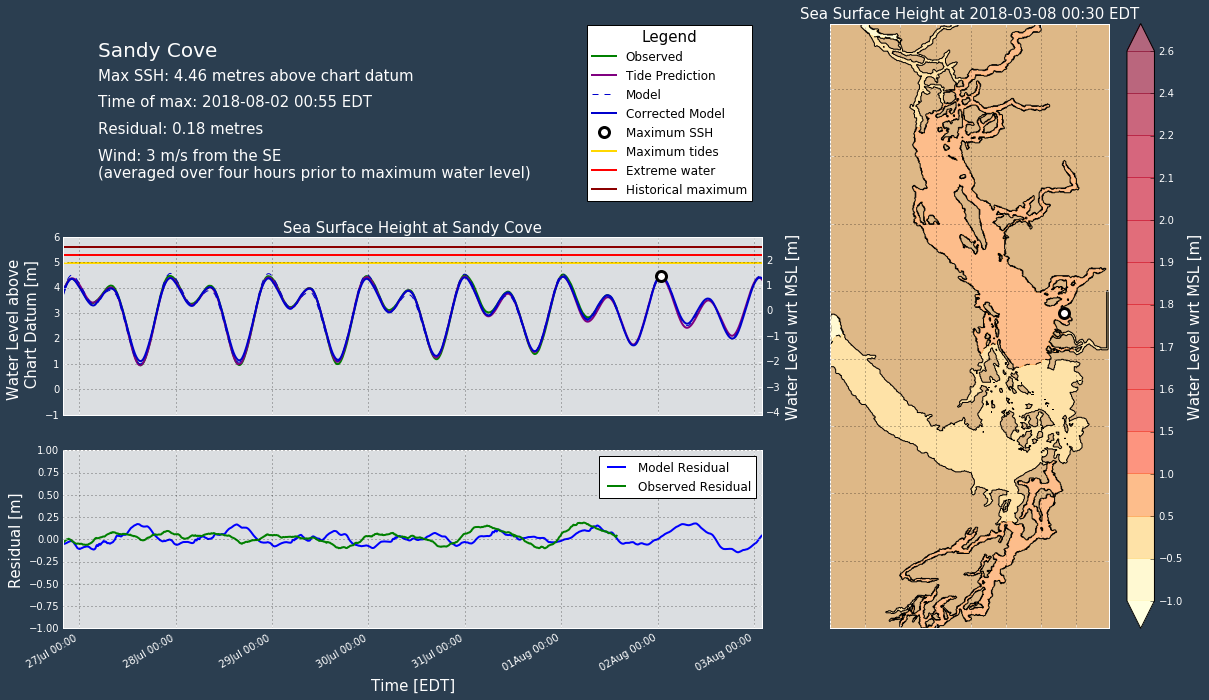

In [13]:
%%timeit -n1 -r1

from importlib import reload
from nowcast.figures import website_theme, shared
from salishsea_tools import places
reload(compare_tide_prediction_max_ssh)
reload(website_theme)
reload(shared)
reload(places)

fig = compare_tide_prediction_max_ssh.make_figure(
    'Sandy Cove', ssh_fcst_dataset_url_tmpl, tidal_predictions, forecast_hrs,
    weather_path, bathy, grid_T_hr_path, theme=website_theme
)